In [114]:
%reload_ext autoreload
%autoreload 2
from pathlib import Path
import wfdb
import sys
sys.path.append("..")

from util import list_patient_id
from preprocessing import match_channels, butter_bandpass_filter, downsample_normalize

In [115]:
path_to_data = Path("/media/hdd1/i-care/training")

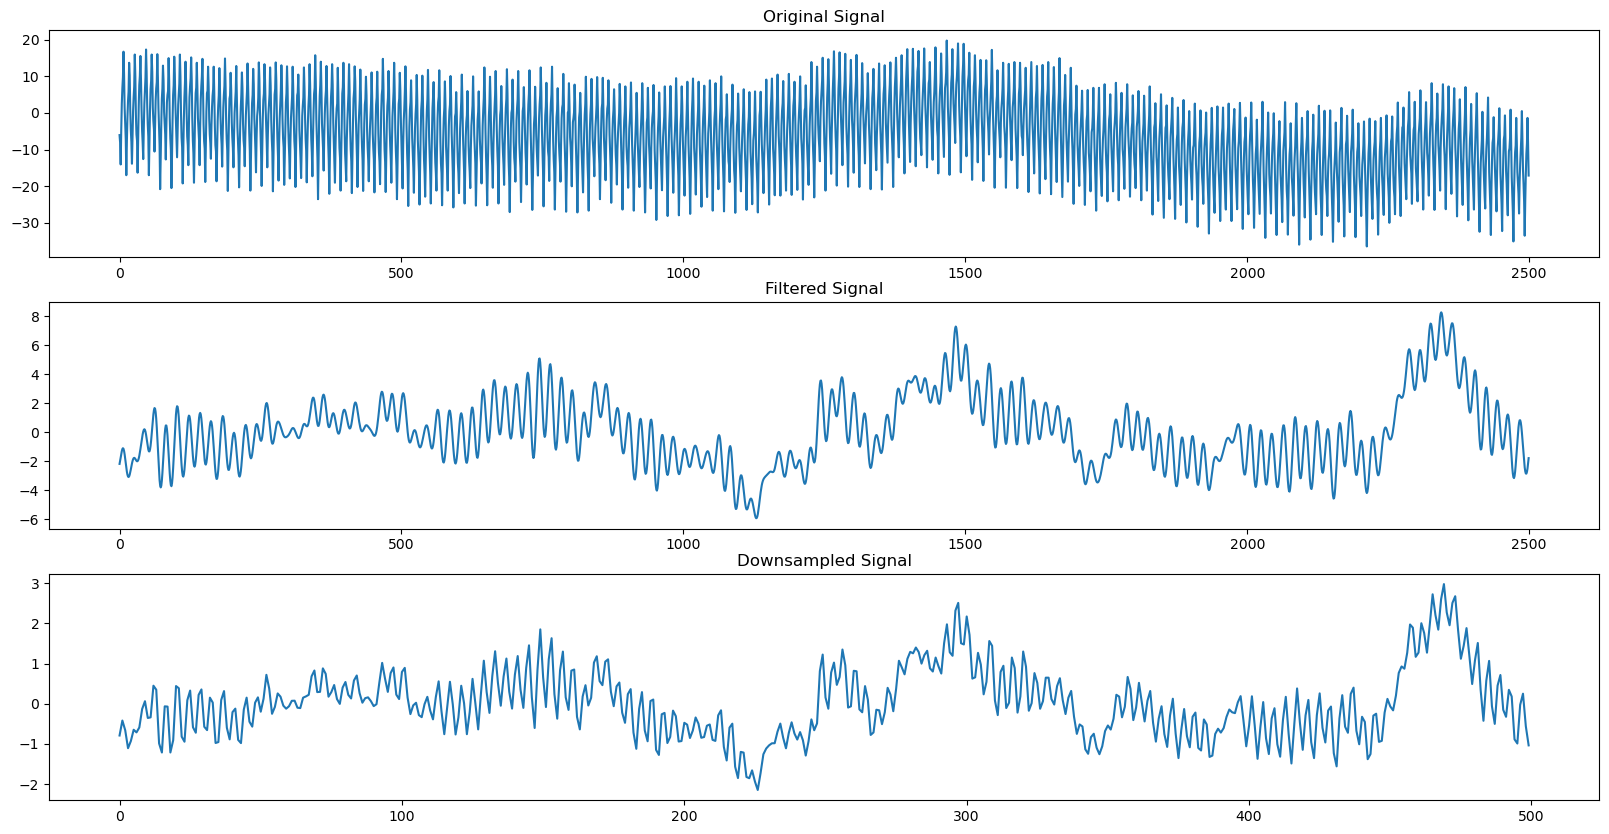

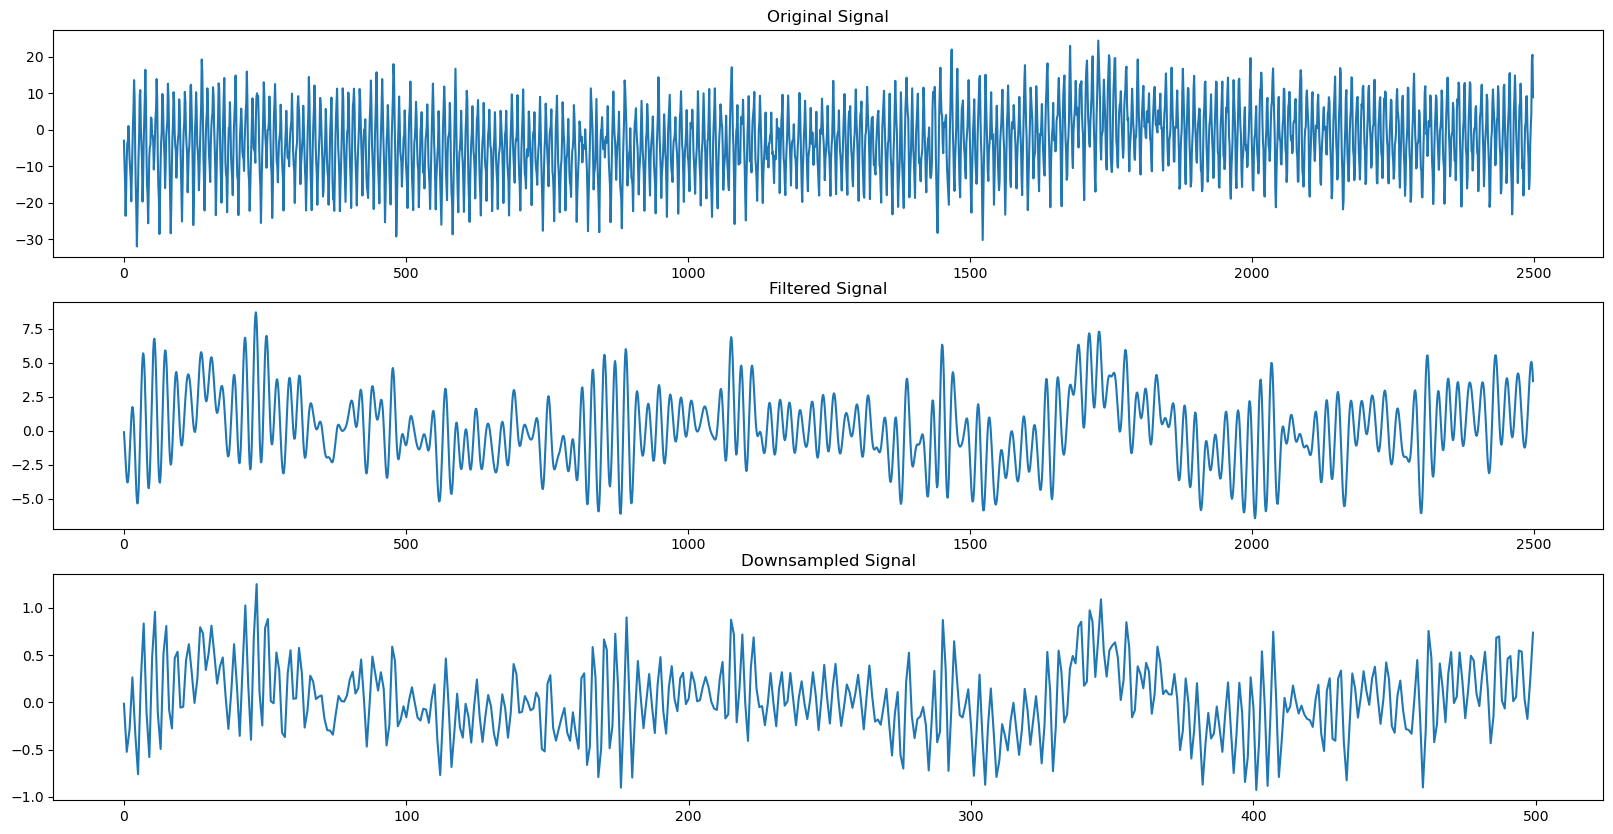

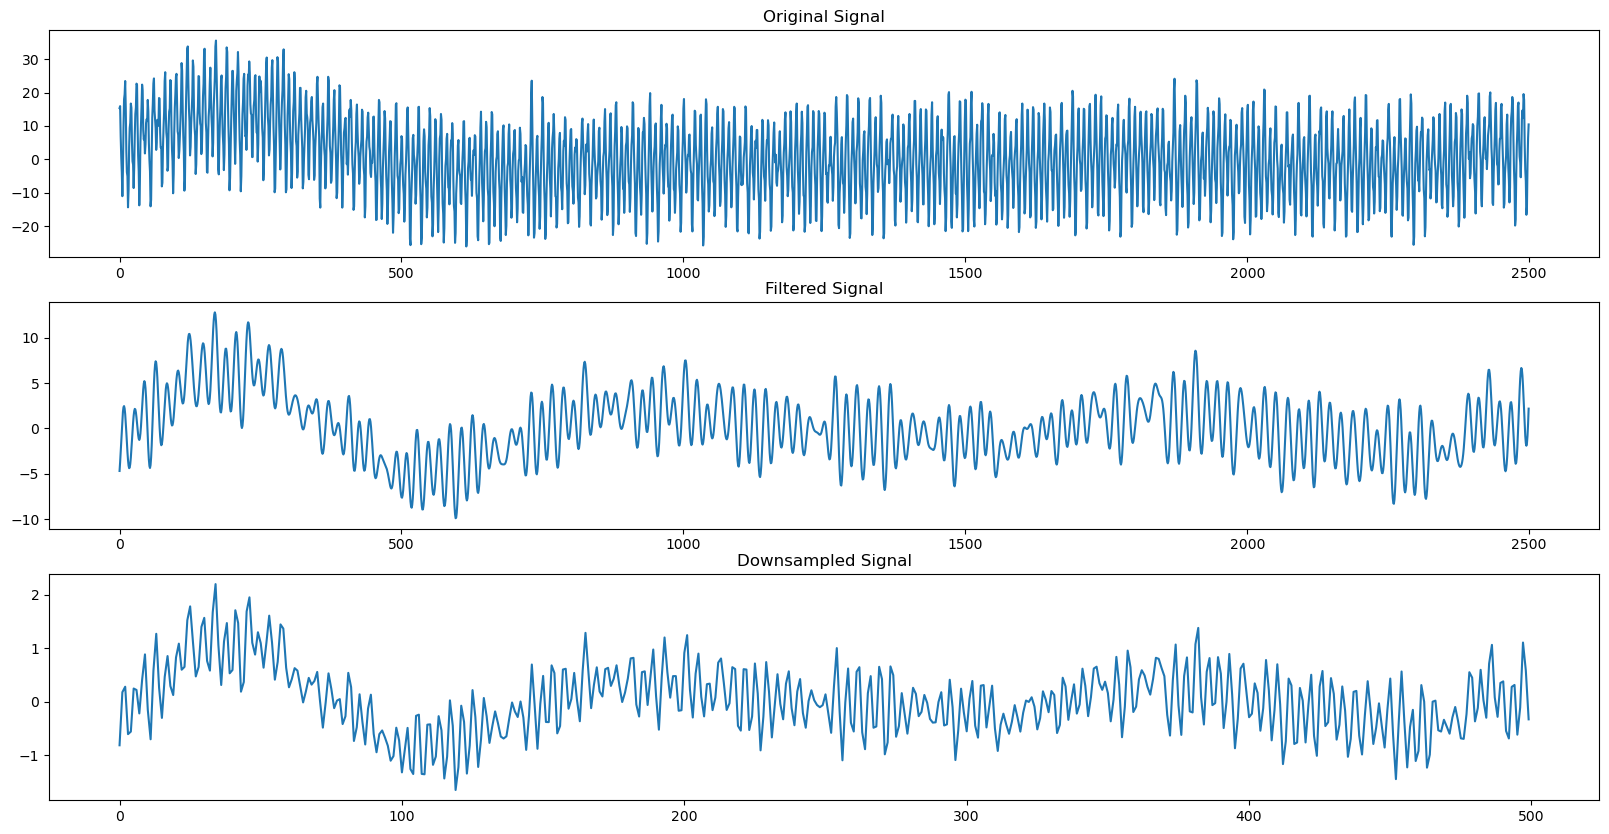

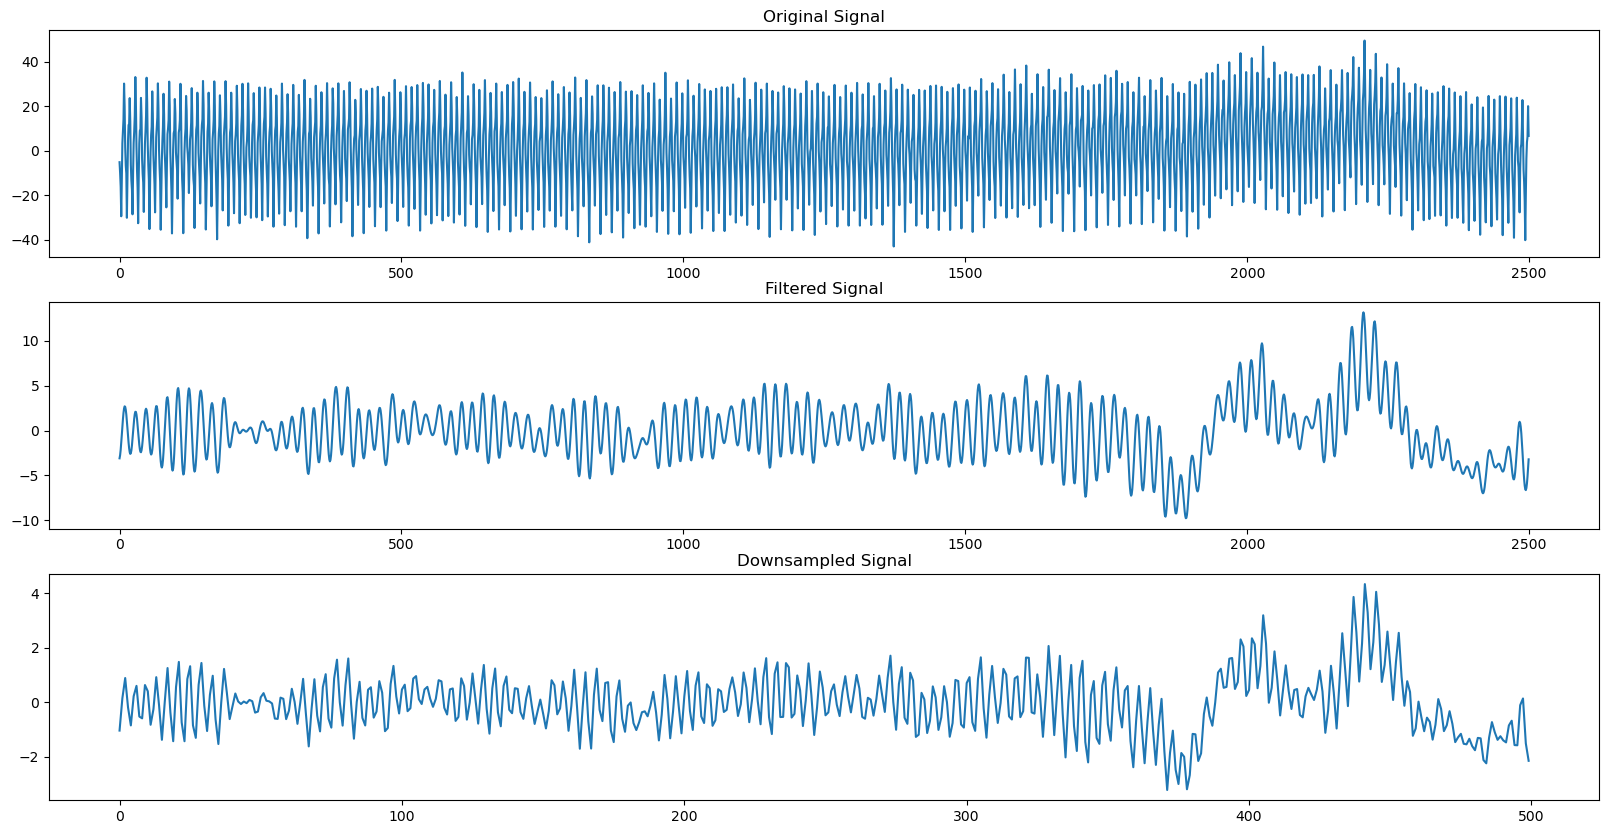

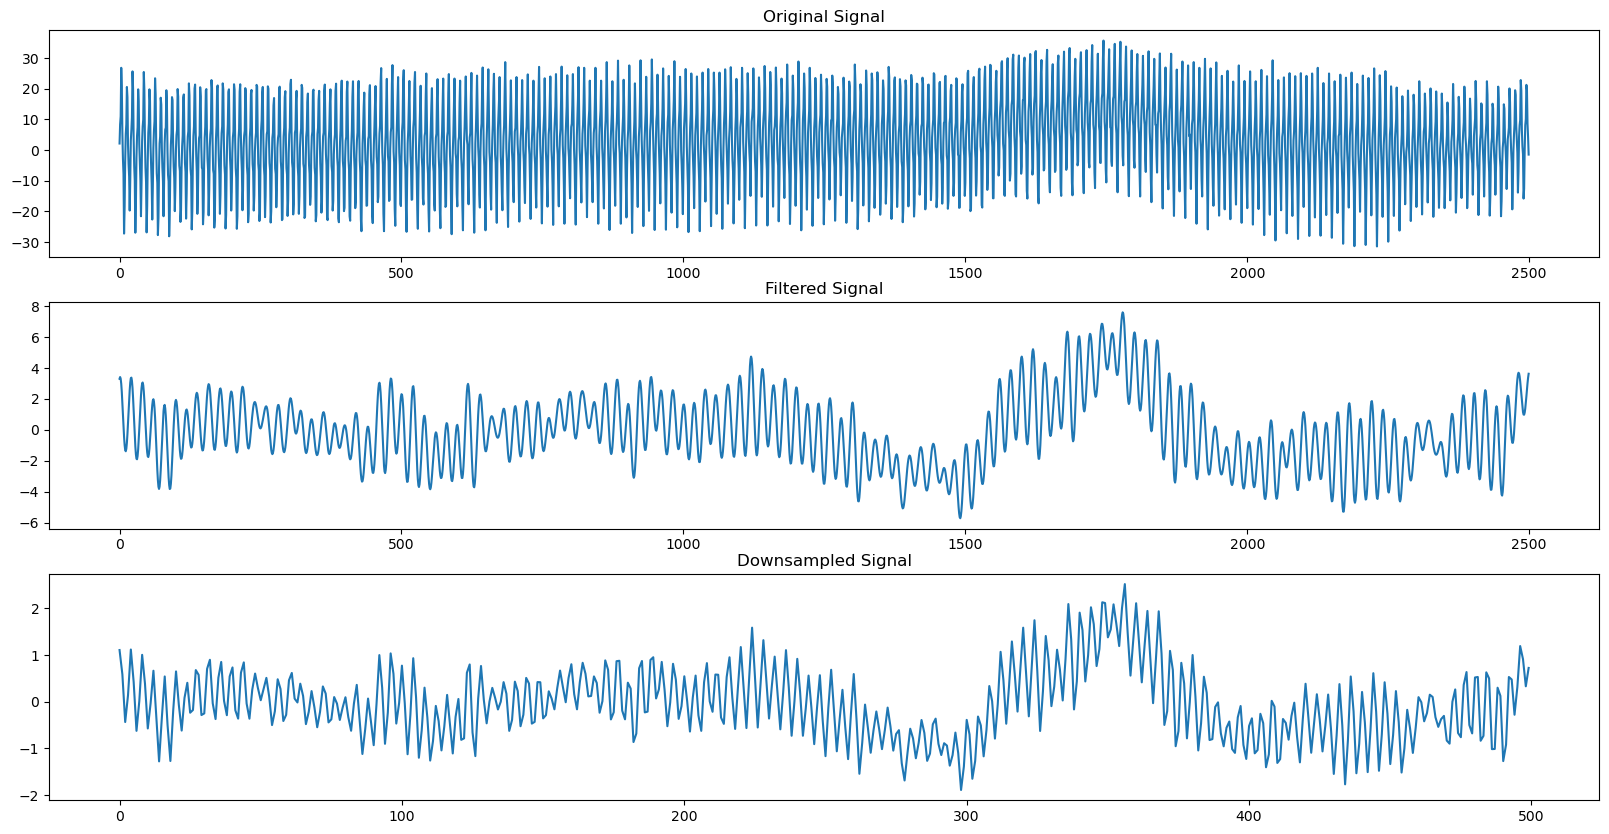

In [136]:
import matplotlib.pyplot as plt
import numpy as np

# For each patient load in EEG segment
for p in list_patient_id(path_to_data)[:1]:
    # Load in each segment of EEG from patient
    eeg_path = path_to_data / p
    for eeg_segment in sorted(set([seg.parent / seg.stem for seg in eeg_path.glob("*EEG.mat")]))[:5]:
        fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))
        # Read in EEG segment, separating the signal and the channels
        eeg_record = wfdb.io.rdrecord(eeg_segment)
        eeg_signal = eeg_record.p_signal
        eeg_channels = eeg_record.sig_name
        fs = eeg_record.fs
        # Remove excess channels and reorder the channels to a standardized order
        reordered_signal = match_channels(eeg_signal, eeg_channels)
        ax[0].plot(reordered_signal[fs*5:fs*10, 0])
        ax[0].set_title("Original Signal")
        # Filter signal with 6th order butterworth bandpass filter
        filtered_signal = butter_bandpass_filter(reordered_signal, fs=fs)
        ax[1].plot(filtered_signal[fs*5:fs*10, 0])
        ax[1].set_title("Filtered Signal")
        # Downsample the data to 100 Hz and perform z-score normalization
        fs_ds = 100
        processed_signal = downsample_normalize(filtered_signal, fs, fs_ds)
        ax[2].plot(processed_signal[fs_ds*5:fs_ds*10, 0])
        ax[2].set_title("Downsampled Signal")

        save_path = Path(str(eeg_segment).replace("training", "processed"))
        save_path.parent.mkdir(parents=True, exist_ok=True)
        np.save(save_path, processed_signal)